Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 35ms/step - accuracy: 0.7355 - loss: 0.8738 - val_accuracy: 0.6694 - val_loss: 1.8650
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9129 - loss: 0.3832 - val_accuracy: 0.9758 - val_loss: 0.1219
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9474 - loss: 0.2474 - val_accuracy: 0.9590 - val_loss: 0.2715
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9256 - loss: 0.3358 - val_accuracy: 0.9468 - val_loss: 0.3872
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9027 - loss: 0.3549 - val_accuracy: 0.7278 - val_loss: 2.1758
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.9071 - loss: 0.3729 - val_accuracy: 0.8141 - val_loss: 0.5422
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.9131 - loss: 0.3457 - val_accuracy: 0.8728 - val_loss: 0.5968
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.9514 

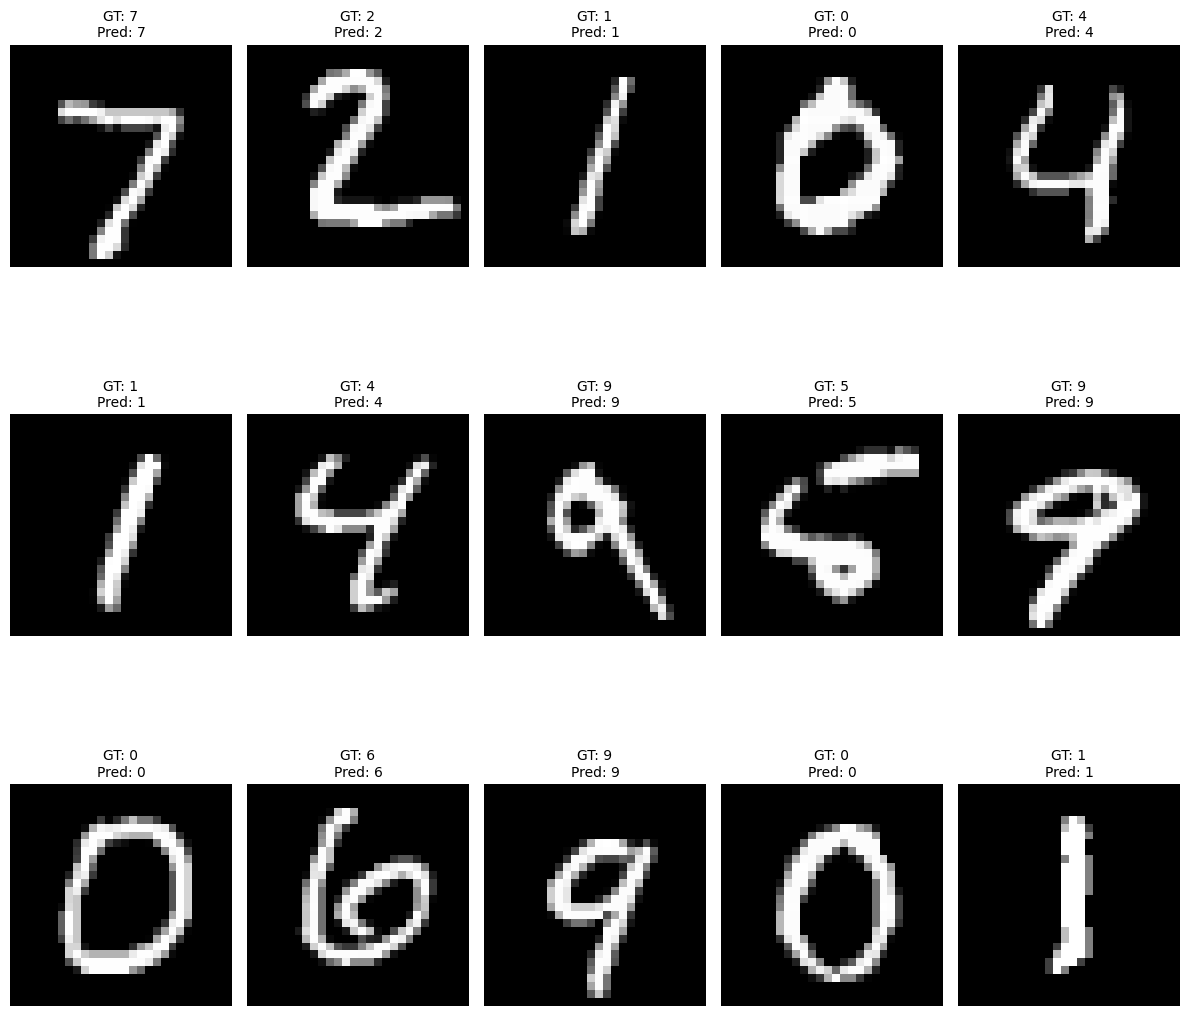

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from math import ceil
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data and reshape for CNN input
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the EfficientNet model
def ConvBlock(filters, kernel_size, strides, padding='same'):
    return models.Sequential([
        layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU()
    ])

def MBBlock(in_channels, out_channels, kernel_size, strides, ratio, reduction=2):
    hidden_dim = in_channels * ratio
    reduced_dim = int(in_channels / reduction)

    def block(inputs):
        x = inputs
        if in_channels != hidden_dim:
            x = ConvBlock(hidden_dim, 3, 1)(x)

        x = ConvBlock(hidden_dim, kernel_size, strides, padding='same')(x)
        x = SqueezeExcitation(hidden_dim, reduced_dim)(x)
        x = layers.Conv2D(out_channels, 1, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return x

    return block

def SqueezeExcitation(in_channels, reduced_dim):
    def block(inputs):
        x = layers.GlobalAveragePooling2D()(inputs)
        x = layers.Reshape((1, 1, in_channels))(x)
        x = layers.Conv2D(reduced_dim, 1, activation='relu')(x)
        x = layers.Conv2D(in_channels, 1, activation='sigmoid')(x)
        return layers.multiply([inputs, x])
    return block

def EfficientNet(model_name, output):
    basic_mb_params = [
        [1, 16, 1, 1, 3],
        [6, 24, 2, 2, 3],
        [6, 40, 2, 2, 5],
        [6, 80, 3, 2, 3],
        [6, 112, 3, 1, 5],
        [6, 192, 4, 2, 5],
        [6, 320, 1, 1, 3],
    ]
    alpha, beta = 1.2, 1.1
    scale_values = {
        "b0": (0, 224, 0.2),
        "b1": (0.5, 240, 0.2),
        "b2": (1, 260, 0.3),
        "b3": (2, 300, 0.3),
        "b4": (3, 380, 0.4),
        "b5": (4, 456, 0.4),
        "b6": (5, 528, 0.5),
        "b7": (6, 600, 0.5),
    }
    phi, resolution, dropout = scale_values[model_name]
    depth_factor, width_factor = alpha * phi, beta * phi
    last_channels = int(1280 * width_factor)

    inputs = layers.Input(shape=(28, 28, 1))
    x = ConvBlock(int(32 * width_factor), 3, 2)(inputs)
    in_channels = int(32 * width_factor)

    for k, c_o, repeat, s, n in basic_mb_params:
        out_channels = 4 * ceil(int(c_o * width_factor) / 4)
        num_layers = ceil(repeat * depth_factor)

        for layer in range(num_layers):
            stride = s if layer == 0 else 1
            x = MBBlock(in_channels, out_channels, n, stride, k)(x)
            in_channels = out_channels

    x = ConvBlock(last_channels, 1, 1)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(output, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Initialize the model for MNIST
model_name = 'b1'
output_class = 10  # MNIST has 10 classes
effnet = EfficientNet(model_name, output_class)

# Compile the model
effnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = effnet.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = effnet.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

# Show predictions on the test dataset
def show_predictions(model, x_test, y_test, num_images=10):
    predictions = model.predict(x_test)
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(ceil(num_images / 5), 5, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title(f"GT: {y_test[i].argmax()}\nPred: {predictions[i].argmax()}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(effnet, x_test, y_test, num_images=15)

In [8]:
effnet.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 14, 14, 17)     │            221 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 14, 14, 17)     │          2,669 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 17)             │              0 │ sequential_2[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 17)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 1, 1, 8)        │            144 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 1, 1, 17)       │            153 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 14, 14, 17)     │              0 │ sequential_2[0][0],    │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 8)      │            136 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 14, 14, 8)      │             32 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 14, 14, 48)     │          3,648 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 7, 7, 48)       │         20,928 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 48)             │              0 │ sequential_4[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 48)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 1, 1, 4)        │            196 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 1, 1, 48)       │            240 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 7, 7, 48)       │              0 │ sequential_4[0][0],    │
│                      

 Total params: 117,025,055 (446.42 MB)

 Trainable params: 39,002,299 (148.78 MB)

 Non-trainable params: 18,156 (70.92 KB)

 Optimizer params: 78,004,600 (297.56 MB)